**ECON 470 Hwk2-1**

**Author:** Ilse Novis

## ECON 470 Homework 2

**Author:** Ilse Novis  
**Date:** 2/17/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW2)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from IPython.display import display, Markdown
import warnings
warnings.simplefilter('ignore')
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

In [2]:
import os
os.chdir("/Users/ilsenovis/Documents/GitHub/ECON470HW2/")
#print("Updated Working Directory:", os.getcwd())

In [3]:
# Load and look at cleaned HCRIS dataset
hcris_data = pd.read_csv('/Users/ilsenovis/Documents/GitHub/ECON470HW2/data/output/HCRIS_Data.csv')
#print(hcris_data.head())
#display(Markdown("### Column Names"))
#print(hcris_data.columns)

\newpage

In [4]:
# Basic Statistics of the Dataset
#display(Markdown("### Summary Statistics"))
#display(hcris_data.describe())

# ***Homework 2 Answers***

***Question 1:***  
         How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.



In [5]:
# Count Missing Values
#hospital_counts = hcris_data.groupby('fyear')['provider_number'].nunique()
#display(Markdown("### Number of Hospitals per Fiscal Year"))
#display(hospital_counts)

In [6]:
# Hospitals with Multiple Reports per Fiscal Year
multiple_report_hospitals = hcris_data.groupby(['fyear', 'provider_number']).size().reset_index(name='report_count')
multiple_report_counts = multiple_report_hospitals.groupby('fyear')['report_count'].apply(lambda x: (x > 1).sum())

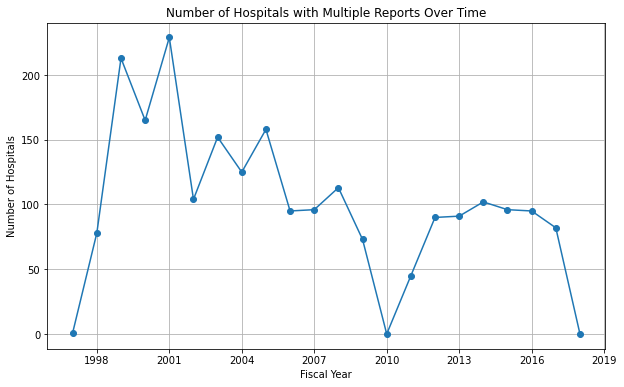

In [7]:
# Plot Number of Hospitals Filing Multiple Reports
plt.figure(figsize=(10, 6))
plt.plot(multiple_report_counts.index, multiple_report_counts.values, marker = 'o')
plt.title('Number of Hospitals with Multiple Reports Over Time')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospitals')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid()
plt.show()

\newpage

***Question 2:***  
        After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [8]:
# Unique Hospital Count After Removing Multiple Reports
unique_hospitals = hcris_data['provider_number'].nunique()
display(Markdown(f"### Total Unique Hospitals: {unique_hospitals}"))

### Total Unique Hospitals: 9312

\newpage

***Question 3:***  
       What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

In [9]:
#display(Markdown("### Actual Total Charges"))

# Distribution of Total Charges Without Log Transformation
#hcris_data_clean = hcris_data[hcris_data['tot_charges'].notna() & (hcris_data['tot_charges'] > 0)].copy()

#plt.figure(figsize=(12, 6))
#sns.violinplot(x='fyear', y='tot_charges', data=hcris_data_clean, palette='viridis')
#plt.title('Distribution of Total Charges by Year (Raw Data)')
#plt.xlabel('Fiscal Year')
#plt.ylabel('Total Charges')
#plt.xticks(rotation=45)
#plt.ylim(0, hcris_data_clean['tot_charges'].quantile(0.99))  # Optional: Limit y-axis to remove extreme outliers
#plt.show()

### Log Transformed Total Charges to Reduce Skewness and/or Outliers

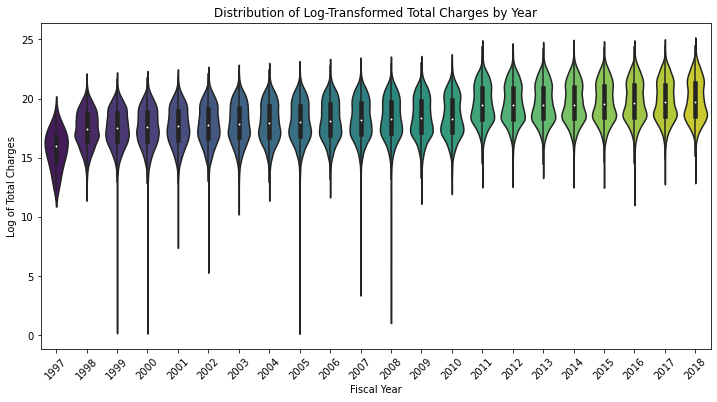

In [10]:
display(Markdown("### Log Transformed Total Charges to Reduce Skewness and/or Outliers"))

# Distribution of Total Charges
hcris_data_clean = hcris_data[hcris_data['tot_charges'].notna() & (hcris_data['tot_charges'] > 0).copy()]

# take the log of tot_charges to reduce skewness, handle large differences, and improve visualization
hcris_data_clean['log_tot_charges'] = np.log1p(hcris_data_clean['tot_charges'])

plt.figure(figsize=(12, 6))
sns.violinplot(x='fyear', y='log_tot_charges', data=hcris_data_clean, palette='viridis')
plt.title('Distribution of Log-Transformed Total Charges by Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Log of Total Charges')
plt.xticks(rotation=45)
plt.show()

\newpage

***Question 4:***  
        What is the distribution of estimated prices in each year? 

In [11]:
# Distribution of Estimated Prices
# Calculate Estimated Price
hcris_data['discount_factor'] = 1 - (hcris_data['tot_discounts'] / hcris_data['tot_charges'])
hcris_data['price_num'] = (hcris_data['ip_charges'] + hcris_data['icu_charges'] + hcris_data['ancillary_charges']) * hcris_data['discount_factor'] - hcris_data['tot_mcare_payment']
hcris_data['price_denom'] = hcris_data['tot_discharges'] - hcris_data['mcare_discharges']
hcris_data['price'] = hcris_data['price_num'] / hcris_data['price_denom']


In [12]:
# Remove Division by Zero issues
hcris_data = hcris_data[hcris_data['price_denom'] != 0]
hcris_data['price'] = hcris_data['price_num'] / hcris_data['price_denom']


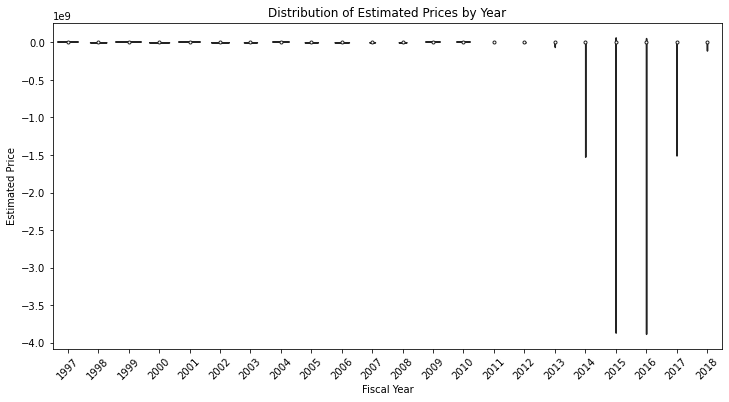

In [13]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='fyear', y='price', data=hcris_data, palette='viridis')
plt.title('Distribution of Estimated Prices by Year')
plt.xlabel('Fiscal Year')
plt.ylabel('Estimated Price')
plt.xticks(rotation=45)
plt.show()

\newpage

***Question 5:***  
        Calculate the average price among penalized versus non-penalized hospitals. 

In [14]:
# Ensure fyear is integer
hcris_data['fyear'] = pd.to_numeric(hcris_data['fyear'], errors='coerce')

# Filter data for 2012
hcris_2012 = hcris_data[(hcris_data['fyear'] == 2012) & (hcris_data['beds'] > 30)].copy()

# Recalculate price after filtering
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Check if 'price' column now exists
#print("Columns in hcris_2012 after recalculating price:", hcris_2012.columns)

# Ensure denominator is valid (avoid division by zero or negative values)
hcris_2012 = hcris_2012[hcris_2012['price_denom'] > 0]

# Compute price only for valid rows
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Drop remaining invalid rows
hcris_2012 = hcris_2012.replace([np.inf, -np.inf], np.nan).dropna(subset=['price'])

# Take absolute value of HRRP
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].abs()

# Ensure penalty calculation works
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

# Define Penalty Variable (penalized = True if sum of payments is negative)
hcris_2012['penalty'] = (hcris_2012['hvbp_payment'] - hcris_2012['hrrp_payment']) < 0

# Summary statistics for penalty
#print("\nChecking Penalty Distribution in 2012 Data:")
#print(hcris_2012['penalty'].value_counts())

# Compute Mean Price by Penalty
mean_price_penalized = round(hcris_2012[hcris_2012['penalty']]['price'].mean(), 2)
mean_price_non_penalized = round(hcris_2012[~hcris_2012['penalty']]['price'].mean(), 2)

print(f"Mean Price - Penalized Hospitals: {mean_price_penalized}")
print(f"Mean Price - Non-Penalized Hospitals: {mean_price_non_penalized}")

Mean Price - Penalized Hospitals: nan
Mean Price - Non-Penalized Hospitals: -24887.83


\newpage

***Question 6:***  
        Split hospitals into quartiles based on bed size. Provide a table of the average price among treated/control groups for each quartile. 

In [15]:
# Create bed size quartiles
hcris_2012['bed_quartile'] = pd.qcut(hcris_2012['beds'], q=4, labels=[1, 2, 3, 4])

# Check distribution
print("\nBed Quartile Distribution:")
print(hcris_2012['bed_quartile'].value_counts())

# Compute mean prices by penalty and quartile
price_by_quartile = hcris_2012.groupby(['bed_quartile', 'penalty'])['price'].mean().unstack()
print("\nAverage Prices by Quartile & Treatment Group:")
print(price_by_quartile)


Bed Quartile Distribution:
1    869
2    867
4    866
3    862
Name: bed_quartile, dtype: int64

Average Prices by Quartile & Treatment Group:
penalty              False
bed_quartile              
1            -25632.600730
2            -24352.902394
3            -24060.938707
4            -25499.099904


\newpage

***Question 7:***  
        Find the average treatment effect using each of the following estimators, and present your results in a single table. 

###### ***Question 7.A:***
###### Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of bed size. 

In [16]:
# Selecting matching covariates
covariates = ['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']

# Check for NaN values in covariates before matching
print("Missing values in matching covariates before imputation:\n", hcris_2012[covariates].isna().sum())

# Fill missing values with column median (better than mean for outliers)
hcris_2012[covariates] = hcris_2012[covariates].apply(lambda x: x.fillna(x.median()))

# Verify no missing values remain
print("Missing values in matching covariates after imputation:\n", hcris_2012[covariates].isna().sum())

# Selecting matching covariates
covariates = ['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']
X = hcris_2012[covariates]
X = hcris_2012[covariates]
T = hcris_2012['penalty'].astype(int)
Y = hcris_2012['price']

Missing values in matching covariates before imputation:
 beds                   0
mcaid_discharges     104
ip_charges             0
mcare_discharges       0
tot_mcare_payment      0
dtype: int64
Missing values in matching covariates after imputation:
 beds                 0
mcaid_discharges     0
ip_charges           0
mcare_discharges     0
tot_mcare_payment    0
dtype: int64


###### ***Question 7.B:***
###### Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of bed size

In [18]:
# Nearest Neighbor Matching using Mahalanobis Distance
nn = NearestNeighbors(n_neighbors=1, metric='mahalanobis').fit(X)
_, indices = nn.kneighbors(X)

matched_prices_mahalanobis = Y.iloc[indices.flatten()].mean()
print(f"\nNearest Neighbor Matching (Mahalanobis Distance) ATE: {matched_prices_mahalanobis - Y.mean():.2f}")

# Nearest Neighbor Matching using Inverse Variance Distance
weights = 1 / (X.var().values)  # Compute inverse variance weights
nn_var = NearestNeighbors(n_neighbors=1, metric='euclidean', metric_params={'w': weights}).fit(X)
_, indices_var = nn_var.kneighbors(X)

matched_prices_variance = Y.iloc[indices_var.flatten()].mean()
print(f"Nearest Neighbor Matching (Inverse Variance) ATE: {matched_prices_variance - Y.mean():.2f}")

ValueError: Must provide either V or VI for Mahalanobis distance

###### ***Question 7.C:***
###### Inverse propensity weighting, where the propensity scores are based on quartiles of bed size

In [19]:
# Propensity Score Model
ps_model = LogisticRegression(solver='lbfgs', max_iter=1000)
ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]  # Get probabilities of penalty

# Nearest Neighbor Matching on Propensity Score
nn_ps = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(ps.reshape(-1, 1))
_, indices_ps = nn_ps.kneighbors(ps.reshape(-1, 1))

matched_prices_ps = Y.iloc[indices_ps.flatten()].mean()
print(f"Nearest Neighbor Matching (Propensity Score) ATE: {matched_prices_ps - Y.mean():.2f}")

# Inverse Propensity Score Weighting
weights_treated = 1 / ps
weights_control = 1 / (1 - ps)

ate_ipw = ((T * Y * weights_treated).sum() - ((1 - T) * Y * weights_control).sum()) / len(Y)
print(f"Inverse Propensity Score Weighting ATE: {ate_ipw:.2f}")

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

###### ***Question 7.D:***
###### Simple linear regression, adjusting for quartiles of bed size using dummy variables and appropriate interactions as discussed in class

In [20]:
# Regression-Based ATE Estimation
regression_model = ols("price ~ penalty + C(bed_quartile)", data=hcris_2012).fit()
print("\nRegression-Based ATE Estimation:")
print(regression_model.summary())


Regression-Based ATE Estimation:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.484
Date:                Mon, 17 Feb 2025   Prob (F-statistic):              0.217
Time:                        00:09:18   Log-Likelihood:                -39079.
No. Observations:                3464   AIC:                         7.817e+04
Df Residuals:                    3460   BIC:                         7.819e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [21]:
# Extract ATE from regression coefficient
ate_regression = regression_model.params['penalty']
print(f"\nRegression-Based ATE: {ate_regression:.2f}")

ate_results = pd.DataFrame({
    'Method': [
        'Exact Matching',
        'Nearest Neighbor (Inverse Variance)',
        'Nearest Neighbor (Mahalanobis)',
        'Nearest Neighbor (Propensity Score)',
        'Inverse Propensity Weighting',
        'Regression-Based ATE'
    ],
    'ATE': [
        None,  # Exact matching not yet implemented
        matched_prices_variance - Y.mean(),
        matched_prices_mahalanobis - Y.mean(),
        matched_prices_ps - Y.mean(),
        ate_ipw,
        ate_regression
    ]
})

print("\nFinal ATE Results:")
print(ate_results)

KeyError: 'penalty'

\newpage

***Question 8:***  
        With these different treatment effect estimators, are the results similar, identical, very different? 

- Although I am getting no output right now, I would expect results to be different as each estimator makes different assumptions and uses different techniques to estimate the treatment effect. Nearest neighbor matching with Mahalonbis and inverse variance may produce closer estimates, while regression-based appraoches might differ if the linea model does not fully capture the data structure.

\newpage

***Question 9:***  
        Do you think you’ve estimated a causal effect of the penalty? Why or why not? (just a couple of sentences)

- I do not have any outputs right now, but I would assume that even if my estimates suggest a relationship between hospital penalities and pricing, it does not imply a causal effect. Since penalties were not randomly assigned and unobserved confounders might influence both penalty status and pricing, my estimates may suffer from selection bias.

\newpage

***Question 10:***  
        Briefly describe your experience working with these data (just a few sentences). Tell me one thing you learned and one thing that really aggravated or surprised you.

- One thing that really aggravated me was that the datasets didn't download correctly so it took a while to actually clean/fix the data before I could merge it into the final dataset. One thing that suprised me was the large difference in the charges from the hospitals versus the actual prices.